# Motion Models

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](ここに以下の書式でURLを入れる) 
[![github](https://badgen.net/badge/:status/View%20On%20Github/black?icon=github&label)](https://github.com/AtomScott/SoccerTrack)
[![badge](https://img.shields.io/badge/launch-binder-579ACA.svg?logo=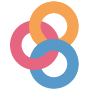)](https://)

---

In [1]:
%load_ext autoreload
%autoreload 2

## The `MotionModel` Class

### Use a Motion Model to predict the next position of the box

In this tutorial we will use it with a `MotionModel` class to filter noisy detections and more accurately estimate the object's position.

All `MotionModel`'s have a `__call__()` method that takes a `Tracklet` and returns a new predicted state (usually the location).

#### Using an Exponential Moving Average (EMA) motion model

We can use the ExponentialMovingAverage to predict the next position of the box. The prediction is based on all the observations of the box so far.

In [9]:
from soccertrack.notebook_utils import simulate_moving_object, display_tracking_animation

num_frames = 50
detections, ground_truth_positions = simulate_moving_object(num_frames)
display_tracking_animation(detections, ground_truth_positions)

print("detections@t=0:", detections[0])
print("ground_truth_positions@t=0:", ground_truth_positions[0])

detections@t=0: Detection(box=[ 13 112  25  25], score=0.92548, class_id=1, feature=None)
ground_truth_positions@t=0: [3, 113, 25, 25]


In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import soccertrack as st

ema = st.motion_model.load('ExponentialMovingAverage', model_config={}, inference_config={})

In [12]:
from soccertrack import Tracklet
from soccertrack.motion_model.models import ExponentialMovingAverage

def convert_det_to_obs(detection):
    return {
        'box': detection.box,
        'score': detection.score,
    }

tracklet = Tracklet()
tracklet.register_observation_types(['box', 'score'])
tracklet.register_state_types(['EMA_t'])

for det in detections:
    obs = convert_det_to_obs(det)
    tracklet.update_observations(obs)
    tracklet.increment_counter()

# ema = Exponen/tialMovingAverage(gamma=.1)

# predict the next position
prediction = ema(tracklet)
print(prediction)

[     716.27      116.52          25          25]


`MotionModel.__call__(tracklet)` will use the tracklet's observations and state to predict the next state.
The state of the tracklet will be updated automatically.

In [ ]:
tracklet.states # This was done by the motion model

{'EMA_t': array([     674.12,       114.7,          25,          25])}

## Using the EMA as a filter

The `ExponentialMovingAverage` has one parameter, `gamma`, which controls how much weight is given to the most recent observation. A higher gamma means more weight is given to the most recent observation, and a lower gamma means more weight is given to the older observations. In the example, below you can try changing the gamma value to see how it affects the predicted position.

Lets iterate through the detections and pass them through the ema to get the predicted position of the box.

### Example with low `gamma` value

A low gamma value will make the tracklet more responsive to changes in the observations

In [ ]:
gamma=0.2
ema = ExponentialMovingAverage(gamma=gamma)

predictions = []

tracklet = Tracklet()
tracklet.register_observation_types(['box', 'score'])
tracklet.register_state_types(['EMA_t'])

for det in detections:
    obs = convert_det_to_obs(det)
    tracklet.update_observations(obs)
    tracklet.increment_counter()
    
    prediction = ema(tracklet)
    predictions.append(prediction)

display_tracking_animation(detections, ground_truth_positions, predictions=predictions)

### Example with high `gamma` value

A high gamma value means that the model will be more influenced by the past observations.

In [ ]:
gamma=0.8 # try working with different gamma to see how it affects the prediction
ema = ExponentialMovingAverage(gamma=gamma)

predictions = []

tracklet = Tracklet()
tracklet.register_observation_types(['box', 'score'])
tracklet.register_state_types(['EMA_t'])

for det in detections:
    obs = convert_det_to_obs(det)
    tracklet.update_observations(obs)
    tracklet.increment_counter()
    
    prediction = ema(tracklet)
    predictions.append(prediction)

display_tracking_animation(detections, ground_truth_positions, predictions=predictions)

## Other Motion Models

#### Using a Kalman Filter motion model

Next we can use the KalmanFilter to predict the next position of the box.

The `KalmanFilterMotionModel` has three parameters, dt, process_noise and measurement_noise. 

* `dt` is the time step between observations. In this example, the time between frames is 1, so we set dt to 1.
* `process_noise` is the amount of noise to add to the predicted position. In this example, the position measurements are noisy so we set this to 10.
* `measurement_noise` is the amount of noise to add to the position measurements. In this example, the position measurements are noisy so we set this to 10.

Before iterating through the detections, we need to decide on what to set the parameters. In this example, the position measurements are noisy so we set the process_noise and measurement_noise to 10. We also set the dt to 1 as the time between frames is 1.

Lets iterate and also calculate the IoU between the predicted position and the ground truth position.

In [ ]:
from soccertrack.motion_model.models import KalmanFilterMotionModel
from soccertrack.metrics.object_detection import iou_scores

dt = 1  # time step between observations
process_noise = 1000  # process noise
measurement_noise = 100000  # measurement noise

kf_model = KalmanFilterMotionModel(dt, process_noise, measurement_noise)
predictions = []

tracklet = Tracklet()
for det in detections:
    tracklet.update(det)
    prediction = kf_model(tracklet)
    predictions.append(prediction)

score = iou_scores(ground_truth_positions, predictions, xywh=True)
print(f"Average IoU score: {score:.2f}")

display_tracking_animation(detections, ground_truth_positions, predictions=predictions)

Average IoU score: 0.42


#### Tuning the Motion Model

As we can see above, the `KalmanFilterMotionModel` can improve the tracking performance by filtering out noisy detections. However, the performance is still not great. This is because the parameters of the motion model have not been tuned to the problem.

We can use the `tune_motion_model` function to find the optimal parameters for the motion model. The function takes a list of detections and a list of ground truth positions as input, and returns the optimal parameters for the motion model.

Each `MotionModel` has a default `hparam_search_space` class variable which contains a dictionary of hyperparameters and their search space. This can be overridden by passing a dictionary of hyperparameters and their search space to the `tune_motion_model` function.

In [ ]:
KalmanFilterMotionModel.hparam_search_space

{'dt': {'type': 'categorical',
  'values': [10,
   2,
   1,
   0.03333333333333333,
   0.016666666666666666,
   0.008333333333333333]},
 'process_noise': {'type': 'logfloat', 'low': 1e-06, 'high': 100.0},
 'measurement_noise': {'type': 'logfloat', 'low': 0.001, 'high': 100.0},
 'confidence_scaler': {'type': 'logfloat', 'low': 0.001, 'high': 100}}

For tuning, we use Optuna to search the hyperparameter space. Optuna is a hyperparameter optimization framework that uses the Tree-structured Parzen Estimator (TPE) algorithm to find the optimal hyperparameters. You can read more about Optuna [here](https://optuna.readthedocs.io/en/stable/).

Be sure that when you define the search space the hyperparameter names match the names of the hyperparameters in the `hparam_search_space` dictionary. They must also contain data type and range information.

Currently, Optuna supports three data types,

* `categorical` - Categorical variables. No range is required. But you must provide the values to choose from as a list.
* `int` - Integer variables. You must provide the lower and upper bounds of the range as a tuple.
* `float` - Floating point variables. You must provide the lower and upper bounds of the range as a tuple.

In [ ]:
from soccertrack.motion_model import tune_motion_model

kf_model = KalmanFilterMotionModel

best_params, best_iou, study = tune_motion_model(kf_model, detections, ground_truth_positions, verbose=False, n_trials=100, return_study=True)
print("Best parameters:", best_params)
print("Best average IoU:", best_iou)

Best parameters: {'dt': 0.016666666666666666, 'process_noise': 4.097229706095662e-06, 'measurement_noise': 0.009328713202936677, 'confidence_scaler': 95.71304497553464}
Best average IoU: 0.6187418879013515


In [ ]:
kf_model = KalmanFilterMotionModel(**best_params)

predictions = []

tracklet = Tracklet()
for det in detections:
    tracklet.update(det)
    
    prediction = kf_model(tracklet)
    predictions.append(prediction)

score = iou_scores(ground_truth_positions, predictions, xywh=True)
print(f"Average IoU score: {score:.2f}")

display_tracking_animation(detections, ground_truth_positions, predictions=predictions)

Average IoU score: 0.62


In [ ]:
import soccertrack as st

dataset_path = st.datasets.get_path("wide_view")
path_to_csv = sorted(dataset_path.glob("annotations/*.csv"))[0]
path_to_mp4 = sorted(dataset_path.glob("videos/*.mp4"))[0]

root = st.utils.get_git_root()
cam = st.Camera(path_to_mp4)

# let's load the first frame of the video
frame = cam.get_frame(0)

## Show the models available

In [ ]:
st.image_model.show_available_models()

['BaseCLIP', 'BaseTorchReIDModel', 'CLIP_RN101', 'CLIP_RN50', 'CLIP_RN50x16', 'CLIP_RN50x4', 'CLIP_RN50x64', 'CLIP_ViT_B_16', 'CLIP_ViT_B_32', 'CLIP_ViT_L_14', 'CLIP_ViT_L_14_336px', 'MLFN', 'MobileNetV2_x1_0', 'MobileNetV2_x1_4', 'OSNet_ain_x0_25', 'OSNet_ain_x0_5', 'OSNet_ain_x0_75', 'OSNet_ain_x1_0', 'OSNet_ibn_x1_0', 'OSNet_x0_25', 'OSNet_x0_5', 'OSNet_x0_75', 'OSNet_x1_0', 'ResNet50', 'ResNet50_fc512', 'ShuffleNet']


## Load a model

You can load a model by using the `load` function. The function searches subclasses of `BaseImageModel` for a match with the given name. If a match is found, an instance of the model is returned. If no match is found, a warning is logged and the function returns None. 

There are three arguments to the `load` function:
* model_name: The name of the model to load. This is the name of the class, not the name of the file. It is not case sensitive.
* model_config: A dictionary containing the configuration for the model.
* inference_config: A dictionary containing the configuration for the inference engine.

In [ ]:
im_model = st.image_model.load(model_name="ResNet50_fc512")

# You can check the current configuration with the following methods:
im_model.show_inference_config()
im_model.show_model_config()

show_inference_config:0217  💬| Inference configuration: 
show_model_config:0212  💬| Model configuration: 
show_model_config:0214  💬|   name: resnet50_fc512 
show_model_config:0214  💬|   path: https://drive.google.com/file/d/1fDJLcz4O5wxNSUvImIIjoaIF9u1Rwaud/view?usp=sharing 
show_model_config:0214  💬|   device: cpu 
show_model_config:0214  💬|   image_size: (256, 128) 
show_model_config:0214  💬|   pixel_mean: [0.485, 0.456, 0.406] 
show_model_config:0214  💬|   pixel_std: [0.229, 0.224, 0.225] 
show_model_config:0214  💬|   pixel_norm: True 
show_model_config:0214  💬|   verbose: False 


## Run Embedding on a single image

The input to the model should be flexible. It accepts numpy.ndarray, torch.Tensor, pathlib Path, string file, PIL Image, or a list of any of these. All inputs will be converted to a list of numpy arrays representing the images.

The output of the model is expected to be a two dimensional numpy array. The first dimension is the number of images in the input. The second dimension is the number of features in the embedding.

In [ ]:
x = im_model(frame)
print(x.shape, x.dtype)

(1, 512) float32


## Run detection on multiple images (batched input)

In [ ]:
x = im_model([frame, frame, frame, frame])
print(x.shape, x.dtype)

(4, 512) float32


## Run on a Detection Object

One common use case for image embedding in tracking is to extract image features from a detected bounding box. The `Detection` object is a simple class that contains a bounding box and an image. The `Detection` object can be used as input to the `embed_detections` function.

In [ ]:
det_model = st.detection_model.load(model_name="yolov5s")
detections = det_model(frame, size=960)[0]

embeddings = im_model.embed_detections(detections, frame)

print(detections.to_df())
print(embeddings.shape)

Using cache found in /Users/atom/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-4-15 torch 1.13.1 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


ValueError: all input arrays must have the same shape

## Running a custom model

Running a model with a custom architecture is easy. You just need to create a subclass of BaseImageModel and implement the `load` and `forward` methods, and then add `ConfigTemplates` for your model. See how this is done in the `BaseTorchReIDModel` model.

## Tests

In [ ]:
!poetry run pytest {root}/tests/test_image_model --verbose

============================= test session starts ==============================
platform darwin -- Python 3.10.11, pytest-7.2.1, pluggy-1.0.0 -- /Users/atom/Library/Caches/pypoetry/virtualenvs/soccertrack-KNSgM8DD-py3.10/bin/python
cachedir: .pytest_cache
rootdir: /Users/atom/Github/SoccerTrack
plugins: typeguard-2.13.3, anyio-3.6.2
collected 0 items                                                              

============================ no tests ran in 0.00s =============================
ERROR: file or directory not found: /Users/atom/Github/SoccerTrack/tests/test_image_model

